Выберите ряд из первого задания и постройте его модель GARCH. Отчет нужно будет оформить в jupyter-ноутбук.

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.tsa.arima.model as smtar

from arch import arch_model
from scipy.stats import boxcox
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [54]:
female_births = pd.read_csv("Series/daily-total-female-births-in-cal.csv")
births = female_births['Count']

In [50]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [51]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

Results of Dickey-Fuller Test:
Test Statistic                  -4.808291
p-value                          0.000052
#Lags Used                       6.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64


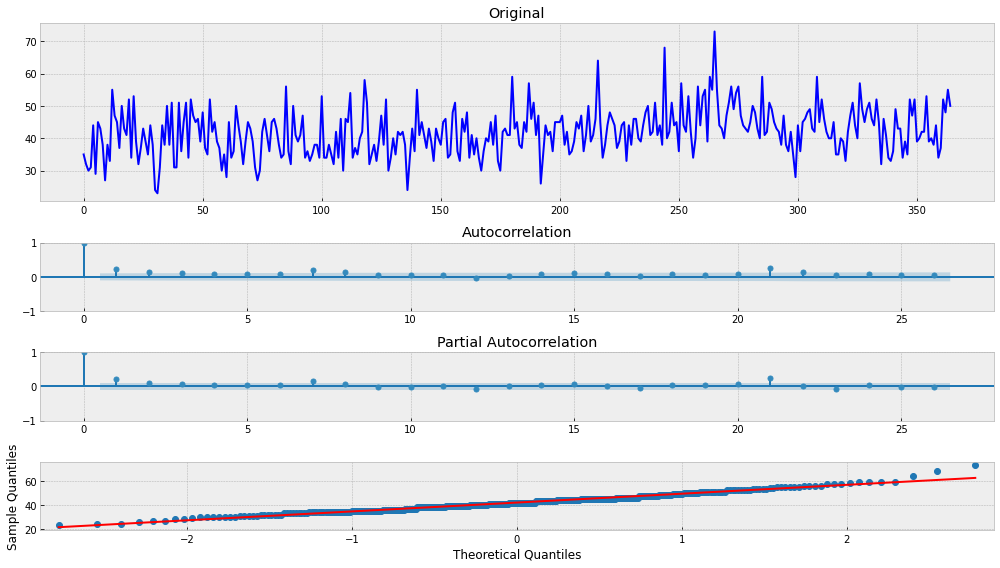

In [55]:
tsplot(births)

aic: 2454.12075 | order: (4, 1, 4)
Results of Dickey-Fuller Test:
Test Statistic                 -19.972861
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    364.000000
Critical Value (1%)             -3.448443
Critical Value (5%)             -2.869513
Critical Value (10%)            -2.571018
dtype: float64
Wall time: 1min 27s


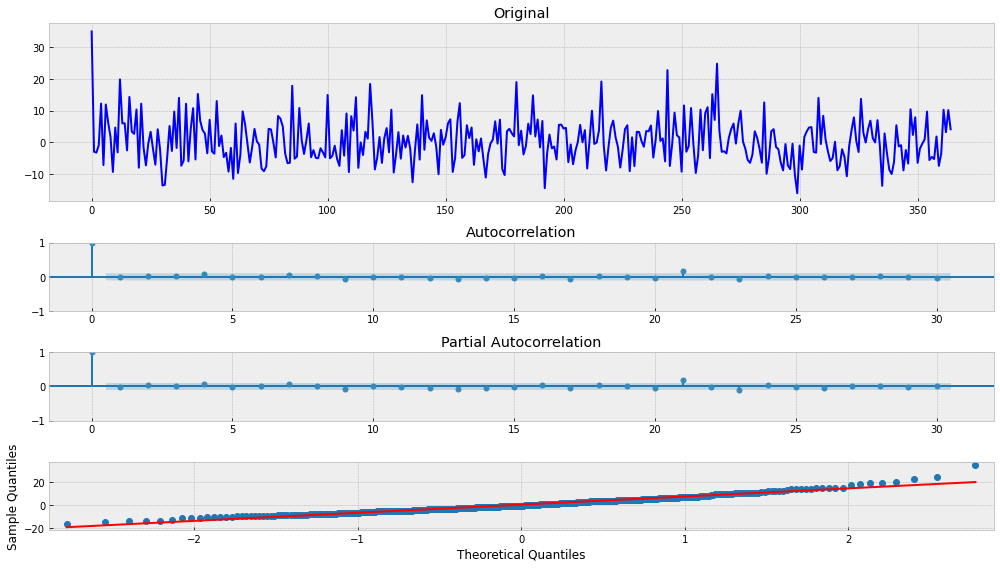

In [36]:
%%time
# Подбираю параметры для GARCH через оптимизацию ARIMA по aic

best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smtar.ARIMA(births, order=(i, d, j)).fit(method='innovations_mle')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue

print(f'aic: {best_aic:6.5f} | order: {best_order}')

tsplot(best_mdl.resid, lags=30)

In [44]:
#Временной ряд изначально стационарен, так что никаких дополнительных действий не требуется.
am = arch_model(births, p=4, o=1, q=4, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                        Count   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -1241.35
Distribution:      Standardized Student's t   AIC:                           2506.70
Method:                  Maximum Likelihood   BIC:                           2553.50
                                              No. Observations:                  365
Date:                      Tue, Jan 18 2022   Df Residuals:                      364
Time:                              16:59:35   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            41

Results of Dickey-Fuller Test:
Test Statistic                  -4.808291
p-value                          0.000052
#Lags Used                       6.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64


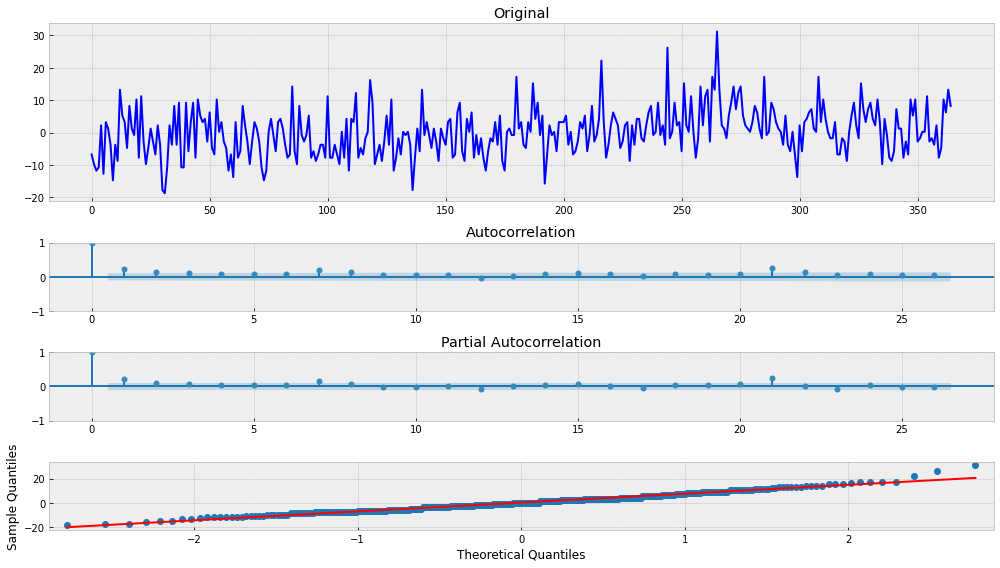

In [45]:
#Остатки распределены нормально, но это распределение очень напоминает исходный временнной ряд.
tsplot(res.resid)

In [84]:
#Предсказанная дисперсия
forecasts = res.forecast(horizon=5, start=360)
forecasts.variance[360:]

,h.1,h.2,h.3,h.4,h.5
360,48.801279,49.328661,45.662140,51.308501,50.842166
361,47.343214,45.561684,55.708421,50.826047,49.631194
362,43.345883,55.596310,50.157883,49.330951,48.750952
363,54.211883,50.087836,59.699145,49.109074,53.544437
364,47.658113,59.576210,50.176852,53.306303,51.600285


In [85]:
#Распределение остатков. Не отличается от основного распределения
forecasts.residual_variance[360:]

,h.1,h.2,h.3,h.4,h.5
360,48.801279,49.328661,45.662140,51.308501,50.842166
361,47.343214,45.561684,55.708421,50.826047,49.631194
362,43.345883,55.596310,50.157883,49.330951,48.750952
363,54.211883,50.087836,59.699145,49.109074,53.544437
364,47.658113,59.576210,50.176852,53.306303,51.600285


In [86]:
#Предсказанное среднее
forecasts.mean[360:]

,h.1,h.2,h.3,h.4,h.5
360,41.761606,41.761606,41.761606,41.761606,41.761606
361,41.761606,41.761606,41.761606,41.761606,41.761606
362,41.761606,41.761606,41.761606,41.761606,41.761606
363,41.761606,41.761606,41.761606,41.761606,41.761606
364,41.761606,41.761606,41.761606,41.761606,41.761606
